# Space Titanic Dataset from Kaggle

Downloading and setting up the libraries

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.utils import Bunch
from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    accuracy_score,
    recall_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve)
from sklearn import set_config

set_config(display="diagram")

In [55]:
from fairlearn.metrics import (
    MetricFrame,
    true_positive_rate,
    false_positive_rate,
    false_negative_rate,
    selection_rate,
    count,
    false_negative_rate_difference
)

from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.postprocessing._interpolated_thresholder import InterpolatedThresholder
from fairlearn.postprocessing._threshold_operation import ThresholdOperation
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds, TruePositiveRateParity

### Data Exploration

In [14]:
df = pd.read_csv('train.csv')

In [15]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [24]:
# Show the values of all binary and categorical features
categorical_values = {}
for col in df:
  if col not in {'PassengerId', 'Age',
                 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Cabin'}:
    categorical_values[col] = pd.Series(df[col].value_counts().index.values)
categorical_values_df = pd.DataFrame(categorical_values).fillna('')
categorical_values_df.T

,0,1,2
HomePlanet,Earth,Europa,Mars
CryoSleep,False,True,
Destination,TRAPPIST-1e,55 Cancri e,PSO J318.5-22
VIP,False,True,
Transported,True,False,


In [26]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(5)
memory usage: 755.7+ KB


<Axes: >

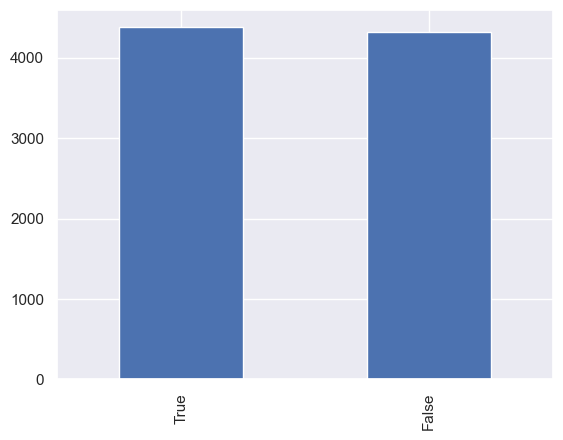

In [84]:
df.Transported.value_counts().plot(kind='bar')

<Axes: >

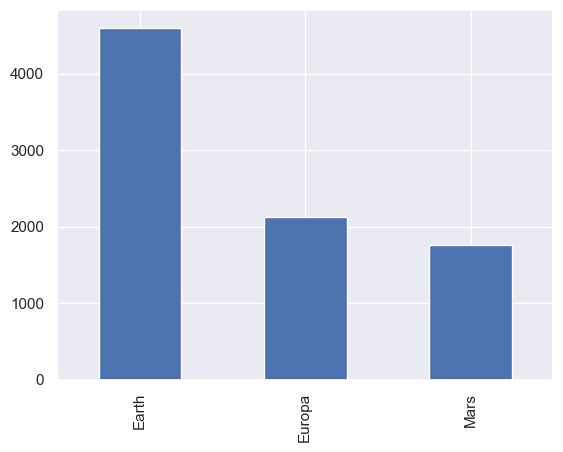

In [85]:
df.HomePlanet.value_counts().plot(kind='bar')

### Understanding the distribution of the columns that has numeric values

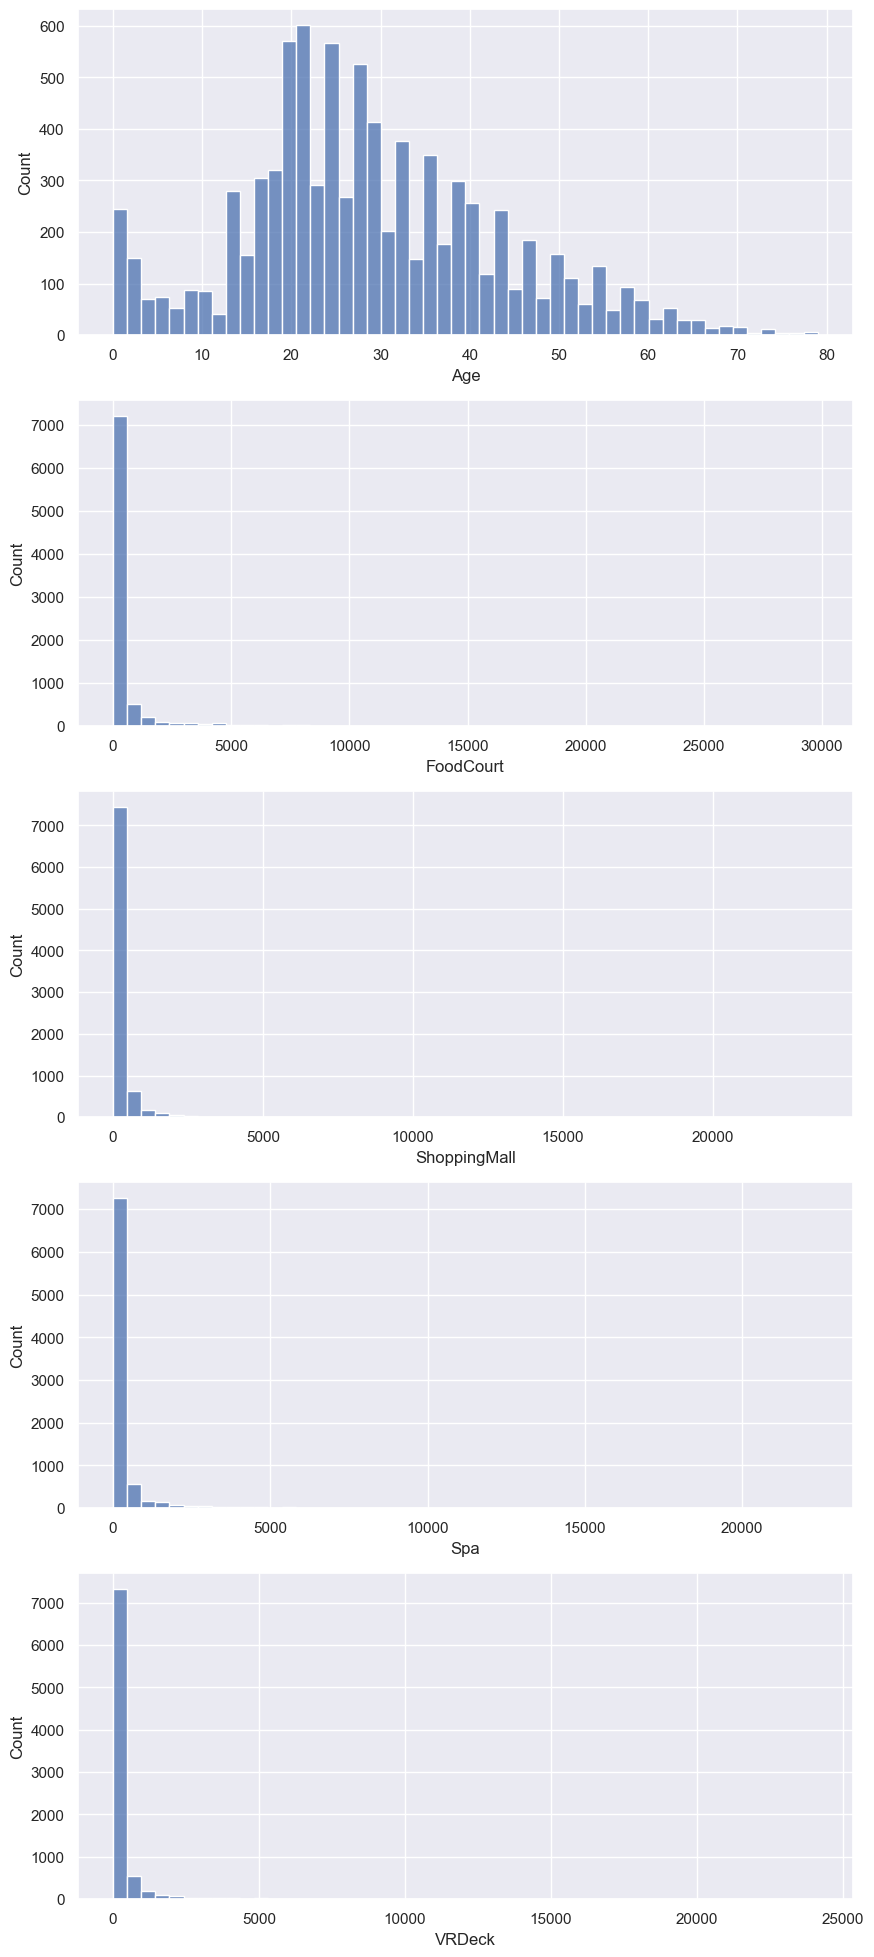

In [232]:
fig, ax = plt.subplots(5,1,  figsize=(10, 10))
plt.subplots_adjust(top = 2)

sns.histplot(df['Age'], color='b', bins=50, ax=ax[0]);
sns.histplot(df['FoodCourt'], color='b', bins=50, ax=ax[1]);
sns.histplot(df['ShoppingMall'], color='b', bins=50, ax=ax[2]);
sns.histplot(df['Spa'], color='b', bins=50, ax=ax[3]);
sns.histplot(df['VRDeck'], color='b', bins=50, ax=ax[4]);

<Axes: >

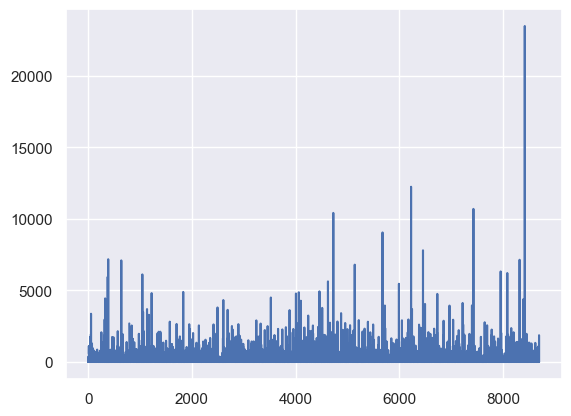

In [239]:
df['ShoppingMall'].plot()

In [28]:
df.isnull().sum().sort_values(ascending=False)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
Transported       0
dtype: int64

In [94]:
df.skew()

/var/folders/l4/t3mpr25116j0g9zz4jw97yfh0000gq/T/ipykernel_83686/1665899112.py:1: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.skew()


CryoSleep        0.591110
Age              0.419097
VIP              6.300900
RoomService      6.333014
FoodCourt        7.102228
ShoppingMall    12.627562
Spa              7.636020
VRDeck           7.819732
Transported     -0.014497
dtype: float64

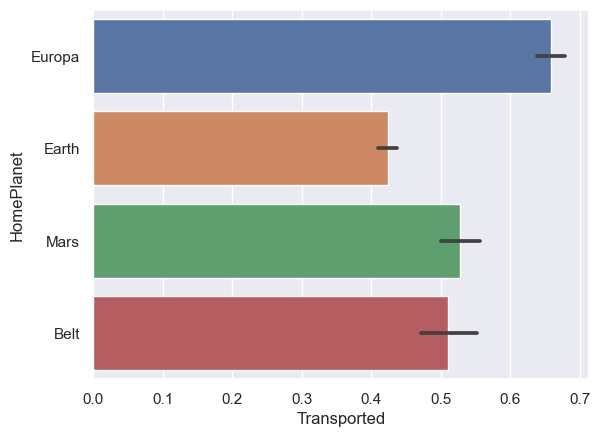

In [227]:
import seaborn as sns
sns.barplot(x="Transported", y="HomePlanet", data=df, errorbar=('ci', 95));

Converting 30% of the records where home planet is Mars to be Belt so there are two smaller groups of origin

In [59]:

# count the number of Europa categories
num_europa = df['HomePlanet'].value_counts()['Mars']

# randomly select 30% of the Europa categories
num_convert = int(np.ceil(0.3 * num_europa))
europa_idx = df.loc[df['HomePlanet'] == 'Mars'].sample(n=num_convert).index

# convert the selected Europa categories to Belt
df.loc[europa_idx, 'HomePlanet'] = 'Belt'


In [32]:


# load the training data
train_df = pd.read_csv('train.csv')

# drop PassengerId and Name columns
train_df.drop(['PassengerId', 'Name', 'Cabin'], axis=1, inplace=True)

# check for null values
print(train_df.isnull().sum())


# fill null values with the median for numeric columns
imputer = SimpleImputer(strategy='median')
train_df[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'VIP']] = imputer.fit_transform(train_df[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','VIP']])

# fill null values with the most frequent value for categorical columns
imputer = SimpleImputer(strategy='most_frequent')
train_df[['HomePlanet','Destination', 'CryoSleep']] = imputer.fit_transform(train_df[['HomePlanet', 'Destination', 'CryoSleep']])

# encode categorical columns as numerical values
train_df = pd.get_dummies(train_df, columns=['HomePlanet', 'Destination', 'CryoSleep'])


# split data into features and target
X = train_df.drop('Transported', axis=1)
y = train_df['Transported']

HomePlanet      201
CryoSleep       217
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
dtype: int64
Age                          0
VIP                          0
RoomService                  0
FoodCourt                    0
ShoppingMall                 0
Spa                          0
VRDeck                       0
HomePlanet_Earth             0
HomePlanet_Europa            0
HomePlanet_Mars              0
Destination_55 Cancri e      0
Destination_PSO J318.5-22    0
Destination_TRAPPIST-1e      0
CryoSleep_False              0
CryoSleep_True               0
dtype: int64


In [ ]:
print(X.isnull().sum())

In [33]:
# Assuming X and y are the input features and target variable respectively
# Create a pipeline with SimpleImputer and DecisionTreeClassifier
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe = Pipeline([
    ('clf', DecisionTreeClassifier())
])

# Fit the pipeline to the data
pipe.fit(X, y)

# Use the pipeline to predict
y_pred = pipe.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.9298447383553766


In [39]:
print(test_df.isnull().sum())

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64


In [50]:
test_df = pd.read_csv('test.csv')
# drop PassengerId and Name columns

test_df_original = test_df.copy()

test_df.drop(['PassengerId', 'Name', 'Cabin'], axis=1, inplace=True)

# check for null values
print(test_df.isnull().sum())

# fill null values with the median for numeric columns
imputer = SimpleImputer(strategy='median')
test_df[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'VIP']] = imputer.fit_transform(test_df[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','VIP']])

# fill null values with the most frequent value for categorical columns
imputer = SimpleImputer(strategy='most_frequent')
test_df[['HomePlanet','Destination', 'CryoSleep']] = imputer.fit_transform(test_df[['HomePlanet', 'Destination', 'CryoSleep']])

# encode categorical columns as numerical values
test_df = pd.get_dummies(test_df, columns=['HomePlanet', 'Destination', 'CryoSleep'])

HomePlanet       87
CryoSleep        93
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
dtype: int64
Age                          0
VIP                          0
RoomService                  0
FoodCourt                    0
ShoppingMall                 0
Spa                          0
VRDeck                       0
HomePlanet_Earth             0
HomePlanet_Europa            0
HomePlanet_Mars              0
Destination_55 Cancri e      0
Destination_PSO J318.5-22    0
Destination_TRAPPIST-1e      0
CryoSleep_False              0
CryoSleep_True               0
dtype: int64


In [ ]:
print(test_df.isnull().sum())

In [51]:
# Use the pipeline to predict
test_df_original

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


In [52]:
# Create a dataframe for submission
submission_df = pd.DataFrame({'PassengerId': test_df_original['PassengerId'], 'Transported': y_pred})

# Save submission file
submission_df.to_csv('submission.csv', index=False)

<Axes: >

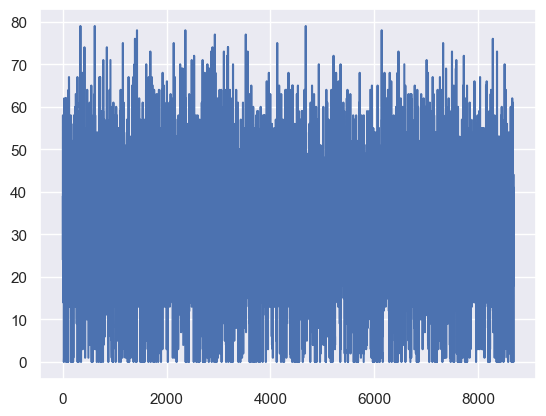

In [21]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

## Bias identification and Mitigation

In [130]:
# load the training data
train_df = pd.read_csv('train.csv')

target_variable = "Transported"
demographic = ["HomePlanet", "Age"]
sensitive = ["HomePlanet"]

train_df.drop(['PassengerId', 'Name', 'Cabin'], axis=1, inplace=True)

# check for null values
print(train_df.isnull().sum())

# fill null values with the median for numeric columns
imputer = SimpleImputer(strategy='median')
train_df[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'VIP']] = imputer.fit_transform(train_df[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','VIP']])

# fill null values with the most frequent value for categorical columns
imputer = SimpleImputer(strategy='most_frequent')
train_df[['HomePlanet','Destination', 'CryoSleep']] = imputer.fit_transform(train_df[['HomePlanet', 'Destination', 'CryoSleep']])


# drop PassengerId and Name columns
X = train_df.drop('Transported', axis=1)
Y, A = train_df.loc[:, target_variable], train_df.loc[:, sensitive]

# encode categorical columns as numerical values
X = pd.get_dummies(X, columns=['HomePlanet', 'Destination', 'CryoSleep'])

HomePlanet      201
CryoSleep       217
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
dtype: int64


In [132]:
# check for null values
print(X.isnull().sum())

Age                          0
VIP                          0
RoomService                  0
FoodCourt                    0
ShoppingMall                 0
Spa                          0
VRDeck                       0
HomePlanet_Earth             0
HomePlanet_Europa            0
HomePlanet_Mars              0
Destination_55 Cancri e      0
Destination_PSO J318.5-22    0
Destination_TRAPPIST-1e      0
CryoSleep_False              0
CryoSleep_True               0
dtype: int64


In [133]:
random_seed = 445
np.random.seed(random_seed)

X_train, X_test, Y_train, Y_test, A_train, A_test, df_train, df_test = train_test_split(
    X,
    Y,
    A,
    train_df,
    test_size=0.50,
    stratify=Y,
    random_state=random_seed
)

In [150]:
# check for null values
print(df_train.isnull().sum())

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64


Downsampling the dataset to match have equal number of positive and negative Y values

In [135]:
def resample_dataset(X_train, Y_train, A_train):
  negative_ids = Y_train[Y_train == 0].index
  positive_ids = Y_train[Y_train == 1].index
  balanced_ids = positive_ids.union(np.random.choice(a=negative_ids, size=len(positive_ids)))

  X_train = X_train.loc[balanced_ids, :]
  Y_train = Y_train.loc[balanced_ids]
  A_train = A_train.loc[balanced_ids, :]
  return X_train, Y_train, A_train

In [136]:
X_train_bal, Y_train_bal, A_train_bal = resample_dataset(X_train, Y_train, A_train)

In [137]:
X_train

,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,CryoSleep_False,CryoSleep_True
5509,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,1,0,0,0,1
7755,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,1,0,1
1254,19.0,0.0,1507.0,0.0,260.0,0.0,0.0,0,0,1,0,0,1,1,0
4572,32.0,0.0,654.0,0.0,655.0,0.0,0.0,0,0,1,0,0,1,1,0
999,38.0,0.0,0.0,3262.0,0.0,295.0,1374.0,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,0,1
8260,25.0,0.0,0.0,145.0,1359.0,492.0,205.0,0,1,0,1,0,0,1,0
4039,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,1,1,0
1815,57.0,1.0,975.0,0.0,295.0,39.0,0.0,0,0,1,0,0,1,1,0


In [138]:
unmitigated_pipeline = Pipeline(steps=[
    ("preprocessing", StandardScaler()),
    ('clf', DecisionTreeClassifier())
])

In [139]:
unmitigated_pipeline.fit(X_train_bal, Y_train_bal)

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('clf', DecisionTreeClassifier())])

In [140]:
Y_pred_proba = unmitigated_pipeline.predict_proba(X_test)[:,1]
Y_pred = unmitigated_pipeline.predict(X_test)

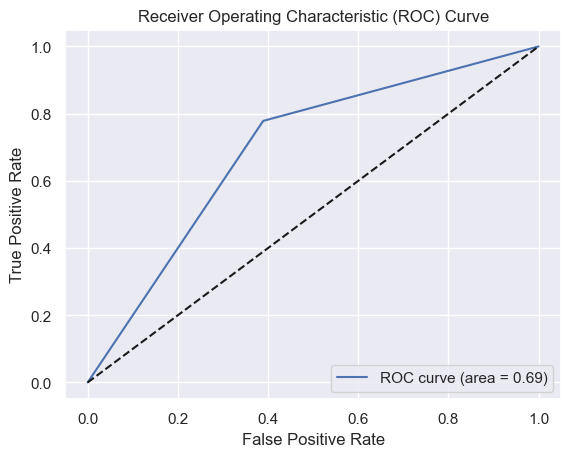

In [108]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = roc_auc_score(Y_test, Y_pred)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # plot the diagonal line representing chance level
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [141]:
balanced_accuracy_score(Y_test, Y_pred)

0.6945941689236477

In [152]:
print(df_test.isnull().sum())

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64


In [153]:
# In its simplest form MetricFrame takes four arguments:
#    metric_function with signature metric_function(y_true, y_pred)
#    y_true: array of labels
#    y_pred: array of predictions
#    sensitive_features: array of sensitive feature values

mf1 = MetricFrame(metrics=false_negative_rate,
                  y_true=Y_test,
                  y_pred=Y_pred,
                  sensitive_features= df_test['HomePlanet'])

# The disaggregated metrics are stored in a pandas Series mf1.by_group:

mf1.by_group

HomePlanet
Earth     0.360544
Europa    0.078621
Mars      0.131034
Name: false_negative_rate, dtype: object

In [154]:
# The largest difference, smallest ratio and worst-case performance are accessed as
#   mf1.difference(), mf1.ratio(), mf1.group_max()

print(f"difference: {mf1.difference():.3}\n"
      f"ratio: {mf1.ratio():.3}\n"
      f"max across groups: {mf1.group_max():.3}")

difference: 0.282
ratio: 0.218
max across groups: 0.361


In [155]:
# You can also evaluate multiple metrics by providing a dictionary

metrics_dict = {
    "selection_rate": selection_rate,
    "false_negative_rate": false_negative_rate,
    "balanced_accuracy": balanced_accuracy_score,
}

metricframe_unmitigated = MetricFrame(metrics=metrics_dict,
                  y_true=Y_test,
                  y_pred=Y_pred,
                  sensitive_features=df_test['HomePlanet'])

# The disaggregated metrics are then stored in a pandas DataFrame:

metricframe_unmitigated.by_group

,selection_rate,false_negative_rate,balanced_accuracy
HomePlanet,,,
Earth,0.527318,0.360544,0.597666
Europa,0.701465,0.078621,0.827175
Mars,0.600715,0.131034,0.778542


In [156]:
# The largest difference, smallest ratio, and the maximum and minimum values
# across the groups are then all pandas Series, for example:

metricframe_unmitigated.difference()

selection_rate         0.174147
false_negative_rate    0.281924
balanced_accuracy      0.229509
dtype: object

In [157]:
# You'll probably want to view them transposed:

pd.DataFrame({'difference': metricframe_unmitigated.difference(),
              'ratio': metricframe_unmitigated.ratio(),
              'group_min': metricframe_unmitigated.group_min(),
              'group_max': metricframe_unmitigated.group_max()}).T

,selection_rate,false_negative_rate,balanced_accuracy
difference,0.174147,0.281924,0.229509
ratio,0.751738,0.218061,0.722539
group_min,0.527318,0.078621,0.597666
group_max,0.701465,0.360544,0.827175


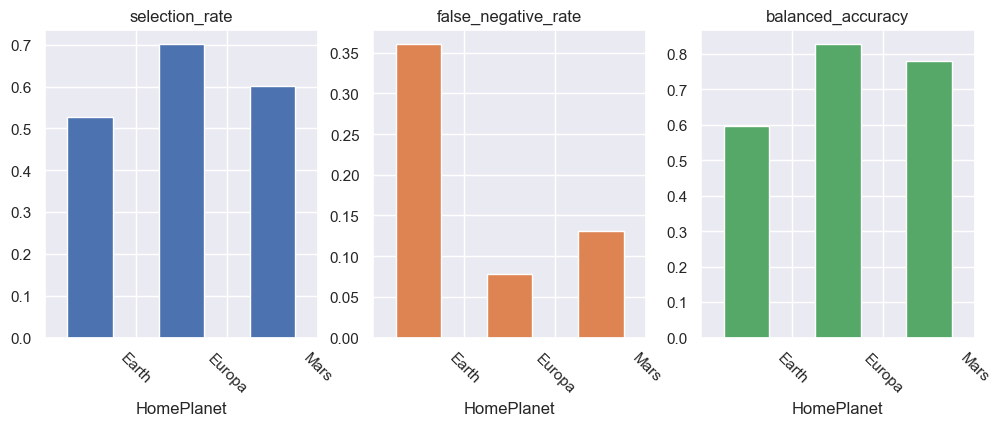

In [158]:
# You can also easily plot all of the metrics using DataFrame plotting capabilities

metricframe_unmitigated.by_group.plot.bar(subplots=True, layout= [1,3], figsize=(12, 4),
                      legend=False, rot=-45, position=1.5);

## Threshold Optimizer

In [159]:
# Now we instantite ThresholdOptimizer with the Decision Tree Classifier
postprocess_est = ThresholdOptimizer(
    estimator=unmitigated_pipeline,
    constraints="false_negative_rate_parity",
    objective="balanced_accuracy_score",
    prefit=True,
    predict_method='predict_proba'
)

In [160]:
postprocess_est.fit(X_train_bal, Y_train_bal, sensitive_features=A_train_bal)

ThresholdOptimizer(constraints='false_negative_rate_parity',
                   estimator=Pipeline(steps=[('preprocessing',
                                              StandardScaler()),
                                             ('clf',
                                              DecisionTreeClassifier())]),
                   objective='balanced_accuracy_score',
                   predict_method='predict_proba', prefit=True)

In [161]:
# Record and evaluate the output of the trained ThresholdOptimizer on test data
Y_pred_postprocess = postprocess_est.predict(X_test, sensitive_features=A_test)
metricframe_postprocess = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=Y_pred_postprocess,
    sensitive_features=A_test
)

In [162]:
pd.concat([metricframe_unmitigated.by_group,
           metricframe_postprocess.by_group],
           keys=['Unmitigated', 'ThresholdOptimizer'],
           axis=1)

Unmitigated                                        \
           selection_rate false_negative_rate balanced_accuracy   
HomePlanet                                                        
Earth            0.527318            0.360544          0.597666   
Europa           0.701465            0.078621          0.827175   
Mars             0.600715            0.131034          0.778542   

           ThresholdOptimizer                                        
               selection_rate false_negative_rate balanced_accuracy  
HomePlanet                                                           
Earth                0.602235             0.24587          0.632292  
Europa               0.690476            0.093793          0.820951  
Mars                 0.586412            0.149425          0.774297

pd.concat([metricframe_unmitigated.difference(),
           metricframe_postprocess.difference()],
          keys=['Unmitigated: difference', 'ThresholdOptimizer: difference'],
          axis=1).T

array([[<Axes: title={'center': 'selection_rate'}, xlabel='HomePlanet'>,
        <Axes: title={'center': 'false_negative_rate'}, xlabel='HomePlanet'>,
        <Axes: title={'center': 'balanced_accuracy'}, xlabel='HomePlanet'>]],
      dtype=object)

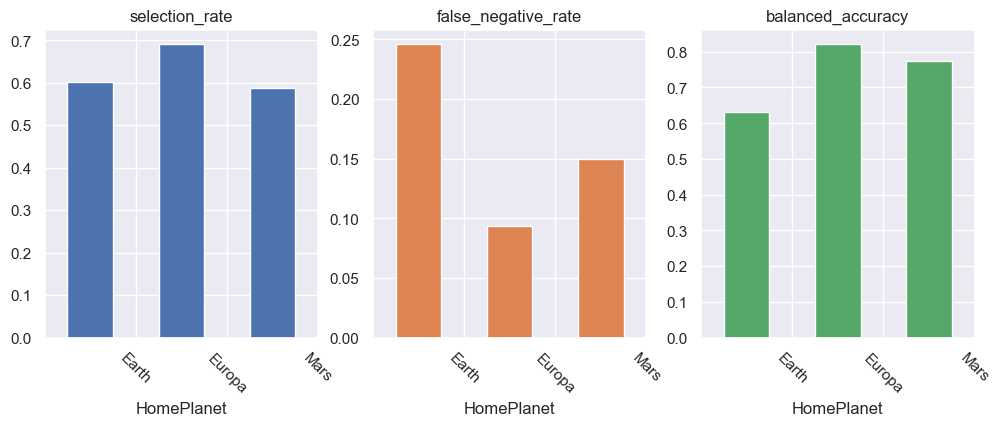

In [165]:
metricframe_postprocess.by_group.plot.bar(subplots=True, layout=[1,3], figsize=(12, 4), legend=False, rot=-45, position=1.5)

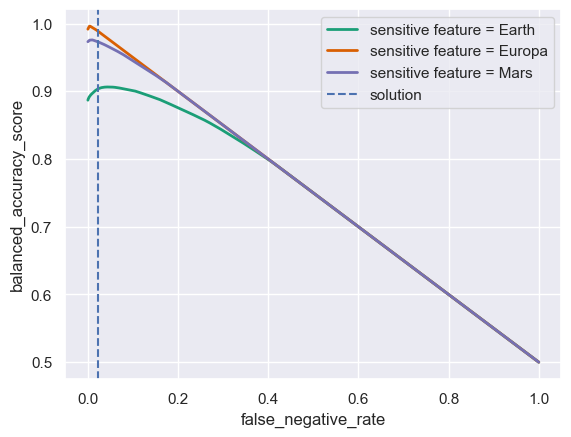

In [207]:
plot_threshold_optimizer(postprocess_est, ax=None, show_plot=True)

### Randomized predictions

In [169]:
interpolated = postprocess_est.interpolated_thresholder_
interpolated

InterpolatedThresholder(estimator=Pipeline(steps=[('preprocessing',
                                                   StandardScaler()),
                                                  ('clf',
                                                   DecisionTreeClassifier())]),
                        interpolation_dict={'Earth': {'operation0': [>0.30952380952380953],
                                                      'operation1': [>0.35416666666666663],
                                                      'p0': 0.9178571428571428,
                                                      'p1': 0.08214285714285718},
                                            'Europa': {'operation0': [>0.95],
                                                       'operation1': [>inf],
                                                       'p0': 0.9945772113943029,
                                                       'p1': 0.005422788605697115},
                                            'Mars': {'operation0': [>0.6904761904761905],
                                                     'operation1': [>0.7321428571428572],
                                                     'p0': 0.969,
                                                     'p1': 0.031000000000000028}},
                        predict_method='predict_proba', prefit=True)

In [170]:
def create_deterministic(interpolate_dict):
  """
  Creates a deterministic interpolation_dictionary from a randomized
  interpolation_dictionary. The determinstic thresholds are created by taking
  the weighted combinations of the two randomized thresholds for each sensitive
  group.
  """
  deterministic_dict = {}
  for (race, operations) in interpolate_dict.items():
    op0, op1 = operations["operation0"]._threshold, operations["operation1"]._threshold
    p0, p1 = operations["p0"], operations["p1"]
    deterministic_dict[race] = Bunch(
      p0=0.0,
      p1=1.0,
      operation0=ThresholdOperation(operator=">",threshold=(p0*op0 + p1*op1)),
      operation1=ThresholdOperation(operator=">",threshold=(p0*op0 + p1*op1))
    )
  return deterministic_dict

In [171]:
deterministic_dict = create_deterministic(interpolated.interpolation_dict)
deterministic_dict

{'Earth': {'p0': 0.0,
  'p1': 1.0,
  'operation0': [>0.3131909013605442],
  'operation1': [>0.3131909013605442]},
 'Europa': {'p0': 0.0, 'p1': 1.0, 'operation0': [>inf], 'operation1': [>inf]},
 'Mars': {'p0': 0.0,
  'p1': 1.0,
  'operation0': [>0.6917678571428572],
  'operation1': [>0.6917678571428572]}}

In [172]:
deterministic_thresholder = InterpolatedThresholder(estimator=interpolated.estimator,
                                                 interpolation_dict=deterministic_dict,
                                                 prefit=True,
                                                 predict_method='predict_proba')

In [173]:
deterministic_thresholder.fit(X_train_bal, Y_train_bal, sensitive_features=A_train_bal)

InterpolatedThresholder(estimator=Pipeline(steps=[('preprocessing',
                                                   StandardScaler()),
                                                  ('clf',
                                                   DecisionTreeClassifier())]),
                        interpolation_dict={'Earth': {'operation0': [>0.3131909013605442],
                                                      'operation1': [>0.3131909013605442],
                                                      'p0': 0.0, 'p1': 1.0},
                                            'Europa': {'operation0': [>inf],
                                                       'operation1': [>inf],
                                                       'p0': 0.0, 'p1': 1.0},
                                            'Mars': {'operation0': [>0.6917678571428572],
                                                     'operation1': [>0.6917678571428572],
                                                     'p0': 0.0, 'p1': 1.0}},
                        predict_method='predict_proba', prefit=True)

In [174]:
y_pred_postprocess_deterministic = deterministic_thresholder.predict(X_test, sensitive_features=A_test)

In [175]:
mf_deterministic = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=y_pred_postprocess_deterministic,
    sensitive_features=A_test
)

In [176]:
mf_deterministic.by_group

,selection_rate,false_negative_rate,balanced_accuracy
HomePlanet,,,
Earth,0.602649,0.24587,0.631932
Europa,0.0,1.0,0.5
Mars,0.586412,0.149425,0.774297


In [177]:
metricframe_postprocess.by_group

,selection_rate,false_negative_rate,balanced_accuracy
HomePlanet,,,
Earth,0.602235,0.24587,0.632292
Europa,0.690476,0.093793,0.820951
Mars,0.586412,0.149425,0.774297


,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,CryoSleep_False,CryoSleep_True
352,23.0,0.0,13.0,747.0,0.0,0.0,128.0,1,0,0,0,0,1,1,0
7945,47.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,0,0,0,1
8450,58.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,1,0,1
719,33.0,0.0,0.0,3879.0,0.0,48.0,67.0,0,1,0,0,0,1,1,0
6379,41.0,0.0,1203.0,756.0,140.0,0.0,0.0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2042,30.0,0.0,0.0,236.0,0.0,1149.0,0.0,1,0,0,0,0,1,1,0
1901,42.0,0.0,399.0,75.0,38.0,771.0,0.0,1,0,0,0,0,1,1,0
6675,51.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,1,0,1
2980,27.0,0.0,16.0,0.0,799.0,0.0,37.0,1,0,0,0,0,1,1,0


In [210]:
expgrad_est = ExponentiatedGradient(
    estimator=DecisionTreeClassifier(random_state=random_seed),
    constraints=TruePositiveRateParity(difference_bound=0.02)
)

In [211]:
# Fit the exponentiated gradient model
expgrad_est.fit(X_train_bal, Y_train_bal, sensitive_features=A_train_bal)

/Users/k2260077/opt/anaconda3/envs/AI_Fairness/lib/python3.10/site-packages/fairlearn/reductions/_moments/utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \
/Users/k2260077/opt/anaconda3/envs/AI_Fairness/lib/python3.10/site-packages/fairlearn/reductions/_moments/utility_parity.py:186: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  expect_event = self.tags.groupby(_EVENT).mean()
/Users/k2260077/opt/anaconda3/envs/AI_Fairness/lib/python3.10/site-packages/fairlearn/reductions/_moments/utility_parity.py:251: FutureWarning: Using the level k

/Users/k2260077/opt/anaconda3/envs/AI_Fairness/lib/python3.10/site-packages/fairlearn/reductions/_moments/utility_parity.py:186: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  expect_event = self.tags.groupby(_EVENT).mean()
/Users/k2260077/opt/anaconda3/envs/AI_Fairness/lib/python3.10/site-packages/fairlearn/reductions/_moments/utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \
/Users/k2260077/opt/anaconda3/envs/AI_Fairness/lib/python3.10/site-packages/fairlearn/reductions/_moments/utility_parity.py:186: FutureWarning: The default value

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.TruePositiveRateParity object at 0x7fb4801f27d0>,
                      estimator=DecisionTreeClassifier(random_state=445),
                      nu=0.0017958446608152448)

In [212]:
# Record and evaluate predictions on test data
Y_pred_reductions = expgrad_est.predict(X_test, random_state=random_seed)
metricframe_reductions = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=Y_pred_reductions,
    sensitive_features=A_test
)
metricframe_reductions.by_group

,selection_rate,false_negative_rate,balanced_accuracy
HomePlanet,,,
Earth,0.543874,0.312925,0.62472
Europa,0.674908,0.082759,0.860528
Mars,0.622169,0.128736,0.758652


In [213]:
# Evaluate the difference between the largest and smallest value of each metric
metricframe_reductions.difference()

selection_rate         0.131034
false_negative_rate    0.230167
balanced_accuracy      0.235808
dtype: object

In [214]:
predictors = expgrad_est.predictors_
predictors

0     DecisionTreeClassifier(random_state=445)
1     DecisionTreeClassifier(random_state=445)
2     DecisionTreeClassifier(random_state=445)
3     DecisionTreeClassifier(random_state=445)
4     DecisionTreeClassifier(random_state=445)
5     DecisionTreeClassifier(random_state=445)
6     DecisionTreeClassifier(random_state=445)
7     DecisionTreeClassifier(random_state=445)
8     DecisionTreeClassifier(random_state=445)
9     DecisionTreeClassifier(random_state=445)
10    DecisionTreeClassifier(random_state=445)
11    DecisionTreeClassifier(random_state=445)
12    DecisionTreeClassifier(random_state=445)
13    DecisionTreeClassifier(random_state=445)
dtype: object

In [215]:
# Collect predictions by all predictors and calculate balanced error
# as well as the false negative difference for all of them

sweep_preds = [clf.predict(X_test) for clf in predictors]
balanced_error_sweep = [1-balanced_accuracy_score(Y_test, Y_sweep) for Y_sweep in sweep_preds]
fnr_diff_sweep = [false_negative_rate_difference(Y_test, Y_sweep, sensitive_features=A_test) for Y_sweep in sweep_preds]

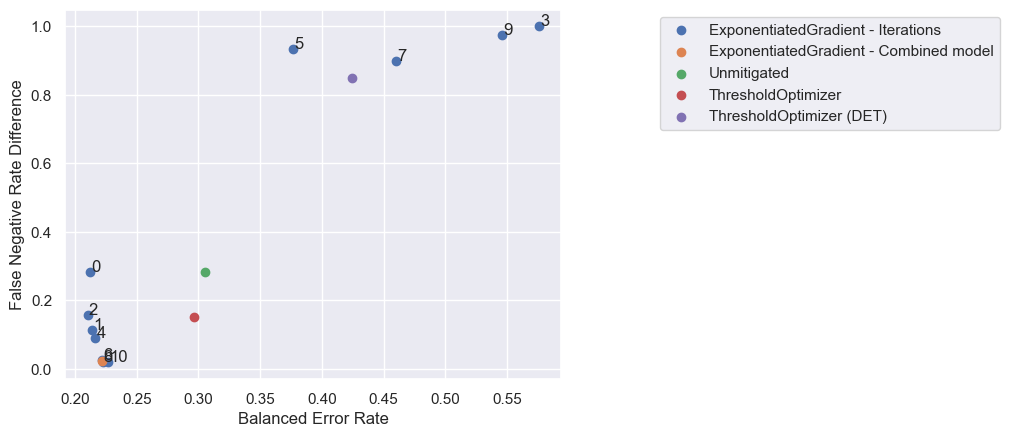

In [190]:
# Show the balanced error / fnr difference values of all predictors on a raster plot  

plt.scatter(balanced_error_sweep, fnr_diff_sweep, label="ExponentiatedGradient - Iterations")
for i in range(len(predictors)):
  plt.annotate(str(i), xy=(balanced_error_sweep[i]+0.001, fnr_diff_sweep[i]+0.001))

# Also include in the plot the combined ExponentiatedGradient model
# as well as the three previously fitted models

plt.scatter(1-balanced_accuracy_score(Y_test, Y_pred_reductions),
            false_negative_rate_difference(Y_test, Y_pred_reductions, sensitive_features=A_test),
            label="ExponentiatedGradient - Combined model")
plt.scatter(1-balanced_accuracy_score(Y_test, Y_pred),
            false_negative_rate_difference(Y_test, Y_pred, sensitive_features=A_test),
            label="Unmitigated")
plt.scatter(1-balanced_accuracy_score(Y_test, Y_pred_postprocess),
            false_negative_rate_difference(Y_test, Y_pred_postprocess, sensitive_features=A_test),
            label="ThresholdOptimizer")
plt.scatter(1-balanced_accuracy_score(Y_test, y_pred_postprocess_deterministic),
            false_negative_rate_difference(Y_test, y_pred_postprocess_deterministic, sensitive_features=A_test),
            label="ThresholdOptimizer (DET)")

plt.xlabel("Balanced Error Rate")
plt.ylabel("False Negative Rate Difference")
plt.legend(bbox_to_anchor=(1.9,1))
plt.show()

In [216]:
def plot_technique_comparison(mf_dict, metric):
  """
  Plots a specified metric for a given dictionary of MetricFrames.
  """
  mf_dict = {k:v.by_group[metric] for (k,v) in mf_dict.items()}
  comparison_df = pd.DataFrame.from_dict(mf_dict)
  comparison_df.plot.bar(figsize=(12, 6), legend=False)
  plt.title(metric)
  plt.xticks(rotation=0, ha='center');
  plt.legend(bbox_to_anchor=(1.01,1), loc='upper left')

In [217]:
test_dict = {
    "Reductions": metricframe_reductions,
    "Unmitigated": metricframe_unmitigated,
    "Postprocessing": metricframe_postprocess
    #"Postprocessing (DET)": mf_deterministic
}

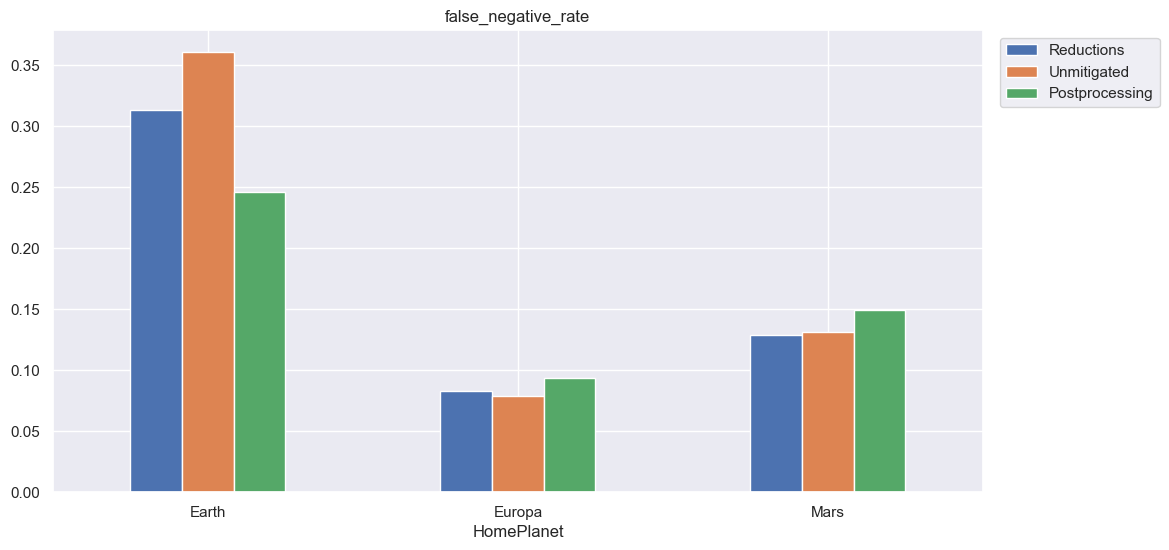

In [218]:
plot_technique_comparison(test_dict, "false_negative_rate")

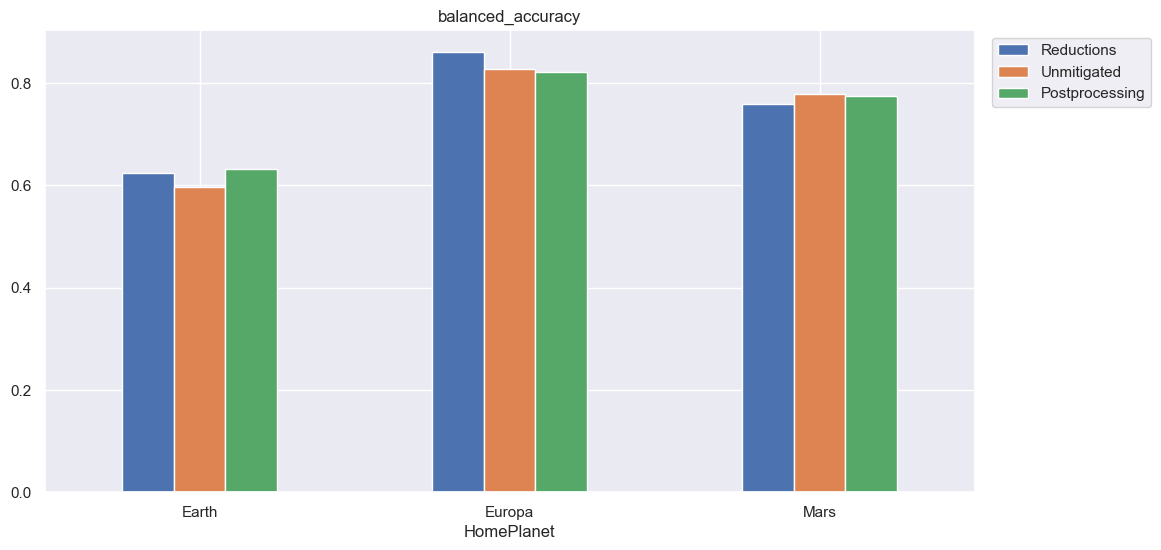

In [219]:
plot_technique_comparison(test_dict, "balanced_accuracy")

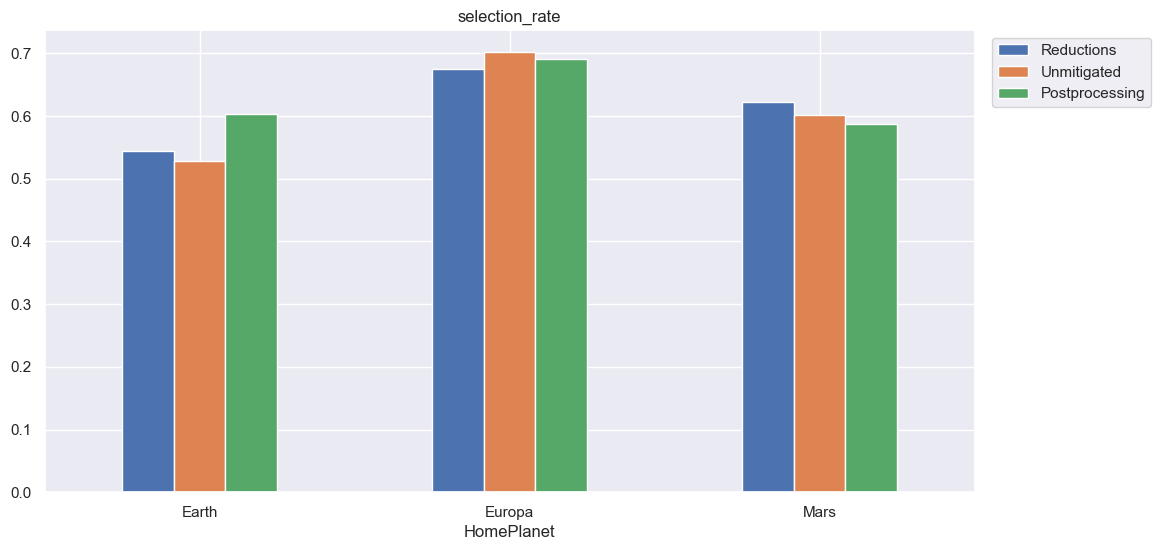

In [220]:
plot_technique_comparison(test_dict, "selection_rate")

In [221]:
overall_df = pd.DataFrame.from_dict({
    "Unmitigated": metricframe_unmitigated.overall,
    "Postprocessing": metricframe_postprocess.overall,
    #"Postprocessing (DET)": mf_deterministic.overall,
    "Reductions": metricframe_reductions.overall
})

In [222]:
overall_df.T

,selection_rate,false_negative_rate,balanced_accuracy
Unmitigated,0.585231,0.221562,0.694594
Postprocessing,0.621348,0.176336,0.703769
Reductions,0.591902,0.200091,0.7095


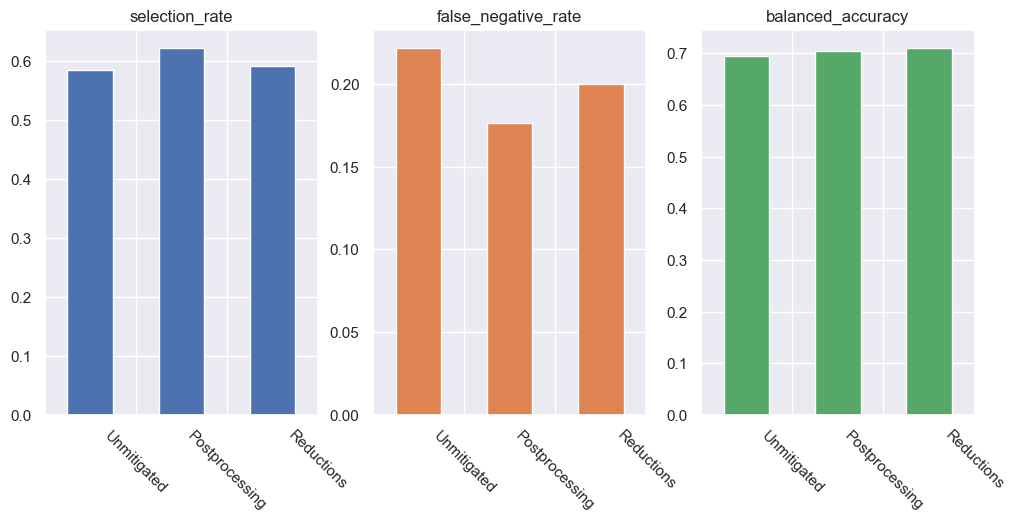

In [223]:
overall_df.transpose().plot.bar(subplots=True, layout= [1,3], figsize=(12, 5), legend=False, rot=-45, position=1.5);

In [224]:
difference_df = pd.DataFrame.from_dict({
    "Unmitigated": metricframe_unmitigated.difference(),
    "Postprocessing": metricframe_postprocess.difference(),
    #"Postprocessing (DET)": mf_deterministic.difference(),
    "Reductions": metricframe_reductions.difference()
}
)

In [225]:
difference_df.T

,selection_rate,false_negative_rate,balanced_accuracy
Unmitigated,0.174147,0.281924,0.229509
Postprocessing,0.104064,0.152077,0.188659
Reductions,0.131034,0.230167,0.235808


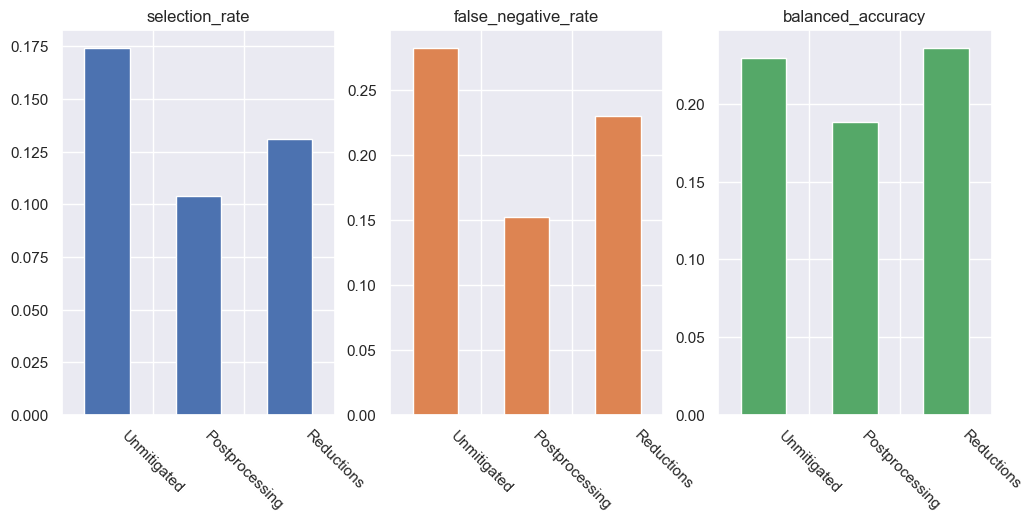

In [226]:
difference_df.T.plot.bar(subplots=True, layout= [1,3], figsize=(12, 5), legend=False, rot=-45, position=1.5);